In [1]:
import os
import pathlib

import numpy as np
from IPython.display import Code

import RATapi as RAT
from RATapi.models import Parameter

# Absorption (imaginary SLD) - effect below the critical edge

RAT allows the use of an imaginary, as well as real part of the SLD. The effect of this is usually seen below the critical edge, and must sometimes be accounted for.

The example used here is Custom Layers. It analyses a bilayer sample on a permalloy / gold substrate, measured using polarised neutrons, against D2O and H2O, leading to 4 contrasts in total. Absorption (i.e. imaginary SLD) is defined for Gold and the Permalloy, to account for non-flat data below the critical edge.

For absorption with standard layers, an additional column appears in the layers block to accommodate the imagainary component of the SLD. For custom functions, we add an extra column to the output.

For all calculation types, to activate this functionality it is necessary to set the 'absorption' flag when creating the project.

In [2]:
problem = RAT.Project(name="Absorption example", calculation="non polarised", model="custom layers", geometry="substrate/liquid", absorption=True)

We now define our parameters, noting that each SLD parameter has both a real and imaginary component:

In [3]:
parameter_list = [
    Parameter(name="Alloy Thickness", min=100.0, value=135.6, max=200.0, fit=True),
    Parameter(name="Alloy SLD up", min=6.0e-6, value=9.87e-6, max=1.2e-5, fit=True),
    Parameter(name="Alloy SLD imaginary up", min=1.0e-9, value=4.87e-8, max=1.0e-7, fit=True),
    Parameter(name="Alloy SLD down", min=6.0e-6, value=7.05e-6, max=1.3e-5, fit=True),
    Parameter(name="Alloy SLD imaginary down", min=1.0e-9, value=4.87e-8, max=1.0e-7, fit=True),
    Parameter(name="Alloy Roughness", min=2.0, value=5.71, max=10.0, fit=True),
    Parameter(name="Gold Thickness", min=100.0, value=154.7, max=200.0, fit=True),
    Parameter(name="Gold Roughness", min=0.1, value=5.42, max=10.0, fit=True),
    Parameter(name="Gold SLD", min=4.0e-6, value=4.49e-6, max=5.0e-6, fit=True),
    Parameter(name="Gold SLD imaginary", min=1.0e-9, value=4.20e-8, max=1.0e-7, fit=True),
    Parameter(name="Thiol APM", min=40.0, value=56.27, max=100.0, fit=True),
    Parameter(name="Thiol Head Hydration", min=20.0, value=30.0, max=50.0, fit=True),
    Parameter(name="Thiol Coverage", min=0.5, value=0.9, max=1.0, fit=True),
    Parameter(name="CW Thickness", min=1.0, value=12.87, max=25.0, fit=True),
    Parameter(name="Bilayer APM", min=48.0, value=65.86, max=90.0, fit=True),
    Parameter(name="Bilayer Head Hydration", min=20.0, value=30.0, max=50.0, fit=True),
    Parameter(name="Bilayer Roughness", min=1.0, value=3.87, max=10.0, fit=True),
    Parameter(name="Bilayer Coverage", min=0.5, value=0.94, max=1.0, fit=True)
]

problem.parameters.extend(parameter_list)

Set the bulk in and bulk out parameters:

In [4]:
problem.bulk_in.set_fields(0, name="Silicon", min=2.0e-6, value=2.073e-6, max=2.1e-6)

problem.bulk_out.set_fields(0, name="D2O", min=5.8e-06, value=6.21e-06, max=6.35e-06, fit=True)
problem.bulk_out.append(name="H2O", min=-5.6e-07, value=-3.15e-07, max=0.0, fit=True)

Use a different scalefactor for each dataset:

In [5]:
del problem.scalefactors[0]
problem.scalefactors.append(name="Scalefactor 1", min=0.5, value=1, max=1.5, fit=True)
problem.scalefactors.append(name="Scalefactor 2", min=0.5, value=1, max=1.5, fit=True)
problem.scalefactors.append(name="Scalefactor 3", min=0.5, value=1, max=1.5, fit=True)
problem.scalefactors.append(name="Scalefactor 4", min=0.5, value=1, max=1.5, fit=True)

Set the backgrounds and resolutions:

In [6]:
del problem.backgrounds[0]
del problem.background_parameters[0]

problem.background_parameters.append(name="Background parameter 1", min=5.0e-08, value=7.88e-06, max=9.0e-05, fit=True)
problem.background_parameters.append(name="Background parameter 2", min=1.0e-08, value=5.46e-06, max=9.0e-05, fit=True)
problem.background_parameters.append(name="Background parameter 3", min=1.0e-06, value=9.01e-06, max=9.0e-05, fit=True)
problem.background_parameters.append(name="Background parameter 4", min=1.0e-06, value=5.61e-06, max=9.0e-05, fit=True)

problem.backgrounds.append(name="Background 1", type="constant", value_1="Background parameter 1")
problem.backgrounds.append(name="Background 2", type="constant", value_1="Background parameter 2")
problem.backgrounds.append(name="Background 3", type="constant", value_1="Background parameter 3")
problem.backgrounds.append(name="Background 4", type="constant", value_1="Background parameter 4")

# Make the resolution fittable
problem.resolution_parameters.set_fields(0, fit=True)


Add the datasets:

In [7]:
data_path = os.path.join(pathlib.Path.cwd().parents[0].resolve(), "data")

data_1 = np.loadtxt(os.path.join(data_path, "D2O_spin_down.dat"))
problem.data.append(name="D2O_dn", data=data_1)

data_2 = np.loadtxt(os.path.join(data_path, "D2O_spin_up.dat"))
problem.data.append(name="D2O_up", data=data_2)

data_3 = np.loadtxt(os.path.join(data_path, "H2O_spin_down.dat"))
problem.data.append(name="H2O_dn", data=data_3)

data_4 = np.loadtxt(os.path.join(data_path, "H2O_spin_up.dat"))
problem.data.append(name="H2O_up", data=data_4)

Add the custom file. We can see that we add an extra column for the output in our custom function.

In [8]:
problem.custom_files.append(
    name="DPPC absorption",
    filename="volume_thiol_bilayer.py",
    language="python",
    path=pathlib.Path.cwd().resolve(),
)
Code(filename='volume_thiol_bilayer.py', language='python')

def volume_thiol_bilayer(params, bulk_in, bulk_out, contrast):
    """VolumeThiolBilayer  RAT Custom Layer Model File.

    This file accepts 3 vectors containing the values for params, bulk in and bulk out.
    The final parameter is an index of the contrast being calculated

    The function should output a matrix of layer values, in the form...

    Output = [thick 1, SLD 1, Rough 1, Percent Hydration 1, Hydrate how 1
              ....
              thick n, SLD n, Rough n, Percent Hydration n, Hydration how n]

    The "hydrate how" parameter decides if the layer is hydrated with Bulk out or Bulk in phases.
    Set to 1 for Bulk out, zero for Bulk in.
    Alternatively, leave out hydration and just return...

    Output = [thick 1, SLD 1, Rough 1,
              ....
              thick n, SLD n, Rough n]

    The second output parameter should be the substrate roughness.
    """
    subRough = params[0]
    alloyThick = params[1]
    alloySLDUp = params[2]
    alloyISLDUp = params[3]
    alloySLDDown = params[4]
    alloyISLDDown = params[5]
    alloyRough = params[6]
    goldThick = params[7]
    goldRough = params[8]
    goldSLD = params[9]
    goldISLD = params[10]
    thiolAPM = params[11]
    thiolHeadHydr = params[12]
    thiolCoverage = params[13]
    cwThick = params[14]
    bilayerAPM = params[15]
    bilHeadHydr = params[16]
    bilayerRough = params[17]
    bilayerCoverage = params[18]

    # Make the metal layers
    gold = [goldThick, goldSLD, goldISLD, goldRough]
    alloyUp = [alloyThick, alloySLDUp, alloyISLDUp, alloyRough]
    alloyDown = [alloyThick, alloySLDDown, alloyISLDDown, alloyRough]

    # Neutron b's..
    # define all the neutron b's.
    bc = 0.6646e-4  # Carbon
    bo = 0.5843e-4  # Oxygen
    bh = -0.3739e-4  # Hydrogen
    bp = 0.513e-4  # Phosphorus
    bn = 0.936e-4  # Nitrogen

    # Work out the total scattering length in each fragment
    # Define scattering lengths
    # Hydrogenated version
    COO = (2 * bo) + (bc)
    GLYC = (3 * bc) + (5 * bh)
    CH3 = (1 * bc) + (3 * bh)
    PO4 = (1 * bp) + (4 * bo)
    CH2 = (1 * bc) + (2 * bh)
    CH = (1 * bc) + (1 * bh)
    CHOL = (5 * bc) + (12 * bh) + (1 * bn)

    # And also volumes
    vCH3 = 52.7  # CH3 volume in the paper appears to be for 2 * CH3's
    vCH2 = 28.1
    vCOO = 39.0
    vGLYC = 68.8
    vPO4 = 53.7
    vCHOL = 120.4
    vCHCH = 42.14

    vHead = vCHOL + vPO4 + vGLYC + 2 * vCOO
    vTail = (28 * vCH2) + (1 * vCHCH) + (2 * vCH3)  # Tail volume

    # Calculate sum_b's for other fragments
    sumbHead = CHOL + PO4 + GLYC + 2 * COO
    sumbTail = (28 * CH2) + (2 * CH) + 2 * CH3

    # Calculate SLDs and Thickness
    sldHead = sumbHead / vHead
    thickHead = vHead / thiolAPM

    sldTail = sumbTail / vTail
    thickTail = vTail / thiolAPM

    # Correct head SLD based on hydration
    thiolHeadHydr = thiolHeadHydr / 100
    sldHead = sldHead * (1 - thiolHeadHydr) + (thiolHeadHydr * bulk_out[contrast])

    # Now correct both the SLDs for the coverage parameter
    sldTail = (thiolCoverage * sldTail) + ((1 - thiolCoverage) * bulk_out[contrast])
    sldHead = (thiolCoverage * sldHead) + ((1 - thiolCoverage) * bulk_out[contrast])

    SAMTAILS = [thickTail, sldTail, 0, goldRough]
    SAMHEAD = [thickHead, sldHead, 0, goldRough]

    # Now do the same for the bilayer
    vHead = vCHOL + vPO4 + vGLYC + 2 * vCOO
    vTail = 28 * vCH2  # Tail volume
    vMe = 2 * vCH3

    sumbHead = CHOL + PO4 + GLYC + 2 * COO
    sumbTail = 28 * CH2
    sumbMe = 2 * CH3

    sldHead = sumbHead / vHead
    thickHead = vHead / bilayerAPM
    bilHeadHydr = bilHeadHydr / 100
    sldHead = sldHead * (1 - bilHeadHydr) + (bilHeadHydr * bulk_out[contrast])

    sldTail = sumbTail / vTail
    thickTail = vTail / bilayerAPM

    sldMe = sumbMe / vMe
    thickMe = vMe / bilayerAPM

    sldTail = (bilayerCoverage * sldTail) + ((1 - bilayerCoverage) * bulk_out[contrast])
    sldHead = (bilayerCoverage * sldHead) + ((1 - bilayerCoverage) * bulk_out[contrast

Finally, add the contrasts:

In [9]:
problem.contrasts.append(
    name="D2O Down",
    data="D2O_dn",
    background="Background 1",
    bulk_in="Silicon",
    bulk_out="D2O",
    scalefactor="Scalefactor 1",
    resolution="Resolution 1",
    resample=True,
    model=["DPPC absorption"],
)

problem.contrasts.append(
    name="D2O Up",
    data="D2O_up",
    background="Background 2",
    bulk_in="Silicon",
    bulk_out="D2O",
    scalefactor="Scalefactor 2",
    resolution="Resolution 1",
    resample=True,
    model=["DPPC absorption"],
)

problem.contrasts.append(
    name="H2O Down",
    data="H2O_dn",
    background="Background 3",
    bulk_in="Silicon",
    bulk_out="H2O",
    scalefactor="Scalefactor 3",
    resolution="Resolution 1",
    resample=True,
    model=["DPPC absorption"],
)

problem.contrasts.append(
    name="H2O Up",
    data="H2O_up",
    background="Background 4",
    bulk_in="Silicon",
    bulk_out="H2O",
    scalefactor="Scalefactor 4",
    resolution="Resolution 1",
    resample=True,
    model=["DPPC absorption"],
)

Now run RAT and plot the results.

Starting RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────

Elapsed time is 0.098 seconds

Finished RAT ───────────────────────────────────────────────────────────────────────────────────────────────────────────



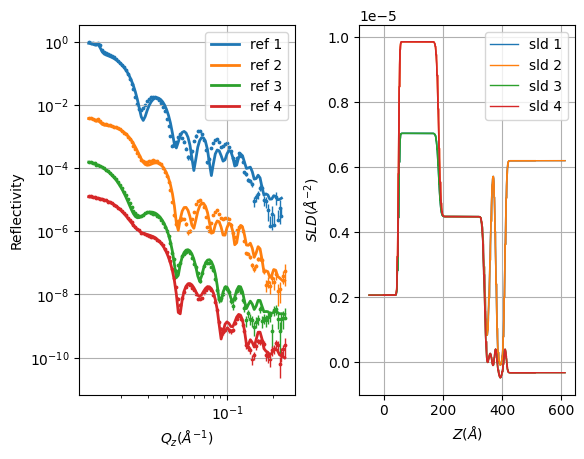

In [10]:
controls = RAT.Controls(parallel="contrasts", resampleParams=[0.9, 150.0])
problem, results = RAT.run(problem, controls)

RAT.plotting.plot_ref_sld(problem, results)